In [256]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

from statsforecast.models import AutoARIMA
from prophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

Скачаем данные и предобработаем данные.

In [93]:
url = 'https://raw.githubusercontent.com/akshaybhalotia/yc_company_scraper/main/data/yc_essential_data.csv'
df = pd.read_csv(url)
drop_columns = ['app_video_public', 'demo_day_video_public', 'app_answers', 'question_answers', 'former_names',
                'highlight_black', 'top_company', 'top_company_by_revenue', 'isHiring', 'nonprofit',
                'tags_highlighted', 'highlight_latinx', 'small_logo_thumb_url', 'highlight_women',
                'launched_at', 'long_description', 'objectID']
df.drop(columns=drop_columns, inplace=True)
df = df.loc[~df["tags"].apply(lambda x: len(x) == 2), :].reset_index(drop=True)
df = df.loc[~df["batch"].apply(lambda x: x[:2] == "IK"), :].reset_index(drop=True)
df.loc[:, "batch"] = df.loc[:, "batch"].apply(lambda x: "20" + x[1:] + ("-07" if x[0] == "S" else "-01") + "-01")
df.rename(columns={"batch": "ds"}, inplace=True)
df

,id,name,slug,website,all_locations,one_liner,team_size,industry,subindustry,tags,ds,status,industries,regions,stage
0,370,Wufoo,wufoo,http://wufoo.com,"Tampa, FL, USA",Online form builder.,11.0,B2B,B2B -> Marketing,"[""SaaS"", ""Productivity""]",2006-01-01,Acquired,"[""B2B"", ""Marketing""]","[""United States of America"", ""America / Canada""]",Early
1,368,Snipshot,snipshot,https://snipshot.com,NaN,We sold Snipshot to Ansa in 2013.,0.0,Consumer,Consumer -> Content,"[""Media""]",2006-01-01,Inactive,"[""Consumer"", ""Content""]","[""Unspecified""]",Growth
2,282,Poll Everywhere,poll-everywhere,https://www.polleverywhere.com,"San Francisco, CA, USA; Remote",Interactive meetings and presentations,70.0,B2B,B2B -> Analytics,"[""SaaS""]",2008-07-01,Active,"[""B2B"", ""Analytics""]","[""United States of America"", ""America / Canada...",Growth
3,291,BackType,backtype,http://backtype.com,"San Francisco, CA, USA",BackType was an analytics company acquired by ...,0.0,B2B,B2B -> Marketing,"[""SaaS"", ""Data Engineering""]",2008-07-01,Acquired,"[""B2B"", ""Marketing""]","[""United States of America"", ""America / Canada""]",Early
4,289,JustSpotted,justspotted,http://justspotted.com,"Copenhagen, Denmark",Acquired by Google in 2011,2.0,Consumer,Consumer -> Content,"[""Artificial Intelligence"", ""ML""]",2008-07-01,Acquired,"[""Consumer"", ""Content""]","[""Denmark"", ""Europe""]",Early
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4030,137,Assembled,assembled,NaN,"Palo Alto, CA, USA","Pivoted to TenXList, a professional network of...",2.0,Consumer,Consumer -> Social,"[""Education"", ""Recruiting""]",2011-01-01,Inactive,"[""Consumer"", ""Social""]","[""United States of America"", ""America / Canada""]",Growth
4031,136,TellFi,tellfi,http://tellfi.com,"San Francisco, CA, USA",Google Voice for business.,2.0,B2B,B2B -> Productivity,"[""Messaging"", ""Enterprise""]",2011-01-01,Inactive,"[""B2B"", ""Productivity""]","[""United States of America"", ""America / Canada""]",Early
4032,135,Beetailer,beetailer,http://beetailer.com,"Mountain View, CA, USA",Facebook stores.,2.0,B2B,B2B -> Retail,"[""E-Commerce"", ""Retail""]",2011-01-01,Inactive,"[""B2B"", ""Retail""]","[""United States of America"", ""America / Canada""]",Early
4033,132,Inporia,inporia,http://inporia.com,"San Francisco, CA, USA",Fashion shopping email list.,11.0,Consumer,Consumer -> Apparel and Cosmetics,"[""E-Commerce"", ""Retail"", ""Fashion""]",2011-01-01,Inactive,"[""Consumer"", ""Apparel and Cosmetics""]","[""United States of America"", ""America / Canada""]",Early


Оставим только колонки с тегами и временные метки. После этого преобразуем теги в списки из тегов, а также объединим по датам.

In [155]:
df_tags = df.loc[:, ("ds", "tags")].copy()
df_tags.loc[:, "tags"] = df_tags.loc[:, "tags"].apply(lambda x: tuple(i[1:-1] for i in x[1:-1].split(", ")))
df_gb = df_tags.groupby(by="ds").agg(np.unique)
def list_unpacker(x):
    objects = Counter()
    for t in x:
        objects.update(t)
    return dict(objects.items())
df_gb.loc[:, "tags"] = df_gb.iloc[:, 0].apply(list_unpacker)

# Посмотрим на все имеющиеся теги
combined_tags = set()
for tag_group in df_gb["tags"]:
    combined_tags.update(tag_group)

# Создадим соответствие теголв и номеров столбцов
tag_nums = dict()
num_tags = dict()
for i, tag in enumerate(combined_tags):
    tag_nums[tag] = i
    num_tags[i] = tag

# Запишем кол-ва тегов в соответствующие колонки
df_one_hot_tags_table = np.zeros((df_gb.shape[0], len(combined_tags)))
for i, row in enumerate(tqdm(df_gb.iterrows())):
    for media, cnt in row[1].iloc[0].items():
        df_one_hot_tags_table[i, tag_nums[media]] +=cnt

38it [00:00, 7280.45it/s]


Создадим из полученных данных таблицу.

In [161]:
# Создаём таблицу
df_one_hot_tags = pd.DataFrame(df_one_hot_tags_table, columns=list(combined_tags))
df_one_hot_tags.index = df_gb.index.copy()
df_one_hot_tags

,Smart Home Assistants,Remote Work,Workflow Automation,Diversity & Inclusion,Mobility,Customization,Note-taking,Blockchain,Art Trading Platforms,AI,...,Travel,Scheduling,Telemedicine,Remittances,Space Exploration,Creator Economy,Personalization,Analytics,Renewable Energy,Ridesharing
ds,,,,,,,,,,,,,,,,,,,,,
2005-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Выберем топовые теги в каждом сезоне и объединим их.

In [196]:
k=5
top_k = np.partition(df_one_hot_tags, -k, axis=1)[:, -k:]  # Results are not sorted
top_k_arg = np.argpartition(df_one_hot_tags, -k, axis=1)[:, -k:]

popular_professions = set()
for i, row in enumerate(top_k_arg):
    popular_professions.update(row[top_k[i] > 0])
len(popular_professions)

40

Теперь отберём подходящие колонки.

In [239]:
df_small_data = df_one_hot_tags.iloc[:, list(popular_professions)].copy()
df_small_data.reset_index(inplace=True)
# df_small_data["unique_id"] = ["current_tag"] * df_small_data.shape[0]
df_small_data

,ds,Calendar,AI,SaaS,Video,Productivity,Data Engineering,Messaging,Artificial Intelligence,Gaming,...,Biotech,Payments,E-Commerce,Hardware,Email,Media,Recommendation System,Fintech,Social Network,Generative AI
0,2005-07-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2006-01-01,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2006-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2007-01-01,0.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,2007-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,2008-01-01,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,2008-07-01,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
7,2009-01-01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,2009-07-01,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0
9,2010-01-01,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0


Теперь обучим на каждый из тегов модель, считая остальные теги экзогенными. Для начала создадим модель.

In [259]:
test_horizon = 4
train_data = df_small_data.iloc[:-test_horizon]
test_data = df_small_data.iloc[-test_horizon:]

# models = [AutoARIMA(season_length=2) for _ in range(df_small_data.shape[1] - 2)]
# model = AutoARIMA(d=0, D=0, season_length=2)

Теперь оубчим такую модель на всех данных.

In [260]:
RMSE_tags = []
MAE_tags = []
MAPE_tags = []

for i in range(1, df_small_data.shape[1] - 1):
    model = Prophet()
    model.fit(train_data.rename(columns={train_data.columns[i]: "y"}))
    preds = model.predict(test_data.drop(columns=[train_data.columns[i]]))["yhat"]
    
    RMSE_tags.append(MSE(test_data[train_data.columns[i]], preds, squared=False))
    MAE_tags.append(MAE(test_data[train_data.columns[i]], preds))
    MAPE_tags.append(MAPE(test_data[train_data.columns[i]], preds))

19:42:57 - cmdstanpy - INFO - Chain [1] start processing
19:42:57 - cmdstanpy - INFO - Chain [1] done processing
19:42:57 - cmdstanpy - INFO - Chain [1] start processing
19:42:57 - cmdstanpy - INFO - Chain [1] done processing
19:42:57 - cmdstanpy - INFO - Chain [1] start processing
19:42:57 - cmdstanpy - INFO - Chain [1] done processing
19:42:57 - cmdstanpy - INFO - Chain [1] start processing
19:42:58 - cmdstanpy - INFO - Chain [1] done processing
19:42:58 - cmdstanpy - INFO - Chain [1] start processing
19:42:58 - cmdstanpy - INFO - Chain [1] done processing
19:42:58 - cmdstanpy - INFO - Chain [1] start processing
19:42:58 - cmdstanpy - INFO - Chain [1] done processing
19:42:58 - cmdstanpy - INFO - Chain [1] start processing
19:42:58 - cmdstanpy - INFO - Chain [1] done processing
19:42:58 - cmdstanpy - INFO - Chain [1] start processing
19:42:58 - cmdstanpy - INFO - Chain [1] done processing
19:42:58 - cmdstanpy - INFO - Chain [1] start processing
19:42:58 - cmdstanpy - INFO - Chain [1]

In [261]:
RMSE_tags

[0.4245622721045331,
 33.56983728738453,
 35.016892366721216,
 1.8303072051149423,
 5.472554881851615,
 3.8005684142161216,
 1.8077591004113356,
 25.68272669044805,
 3.119594037559713,
 0.8828654805003059,
 1.7041904457839259,
 24.256342902763713,
 7.083805640649104,
 1.6274315789783476,
 3.012347966961339,
 14.820138022453449,
 4.149612032928306,
 9.869287797494644,
 3.0568125293994473,
 1.6430834348001802,
 7.4208379009314775,
 9.316135480611157,
 0.6267651895777081,
 0.8881246387234097,
 6.4211503546501305,
 4.683220029206512,
 1.7176642770055421,
 1.8592218681393071,
 7.393339715239485,
 49.61574229531357,
 5.210284121268016,
 8.154892824515862,
 2.168477479140177,
 5.444117096018505,
 0.8440148464207302,
 1.5076423210530316,
 0.7681358526544685,
 21.500057562687246,
 0.7837085351805221]

In [262]:
MAE_tags

[0.4223000193235055,
 23.965180779987637,
 29.446696924745012,
 1.3769387612425499,
 4.974544480951145,
 3.6751556484550196,
 1.498997663765029,
 22.803782982531214,
 2.599130378269357,
 0.7795335517112338,
 1.3109235452175576,
 22.222752052531632,
 6.994244633717268,
 1.4141250830237537,
 2.584040621197424,
 13.830010454304826,
 3.8644759612096156,
 8.108628223506702,
 2.204589245175613,
 1.4087372811317198,
 5.777776235947713,
 8.26369348131891,
 0.6193907622482396,
 0.8794647131437611,
 6.120851229339227,
 3.2678072530688045,
 1.6529189659560173,
 1.6859642726645925,
 6.488243365490039,
 47.918946591826696,
 4.288167297187798,
 7.123632265115444,
 2.1522742879320624,
 5.392105803268345,
 0.7268151708680176,
 1.5062639569392327,
 0.5699935783098871,
 17.1461498355629,
 0.7807513508132289]

In [263]:
MAPE_tags

[1901870209663892.8,
 0.5940978833153923,
 3.2863864018979716,
 3605928078123313.0,
 8122889730908064.0,
 1.522267609099539,
 3578395858062272.5,
 1.0140525060227954,
 5974696608364659.0,
 1547682911689004.5,
 1274816499436966.0,
 1.2368575221049485,
 9994836884256934.0,
 0.8720118812678157,
 5898872028902106.0,
 2.481604481562078e+16,
 1.5965852565563624e+16,
 1.7531566872925984e+16,
 5878070585380405.0,
 4769518007466265.0,
 5841163112627929.0,
 8841870099397684.0,
 2789488006057899.5,
 3017400318448023.5,
 0.7313617407088141,
 9519067696485022.0,
 2705492104007305.5,
 2571969812522179.5,
 1.3052272367953068e+16,
 2.236438060772381,
 9351422252819888.0,
 7502118206965639.0,
 9692981681129936.0,
 1.3821486010774808e+16,
 1276289045055396.0,
 3343371139193675.0,
 127570116925150.05,
 4.052012080885421e+16,
 3516191492591469.0]

Как видно, некоторые теги удаётся предсказать гораздо лучше, чем другие. Однако, для врменных рядов этот датасет сам по себе достаточно маленький. Возьмём теги, которые получилось предскзаать улчше всего, и попробуем предсказать их на будущий период.

In [278]:
good_tags = np.argwhere(np.array(MAPE_tags) < 1.0).flatten()
good_data = df_small_data.iloc[:, np.hstack([np.zeros(1, dtype=int), good_tags + 1])]
preds = []

for i, tag in enumerate(good_data.columns[1:]):
    model = Prophet()
    model.fit(good_data.rename(columns={tag: "y"}))
    preds.append(model.predict(pd.DataFrame(np.array(["2024-07-01"]), columns=["ds"])))

21:10:10 - cmdstanpy - INFO - Chain [1] start processing
21:10:10 - cmdstanpy - INFO - Chain [1] done processing
21:10:11 - cmdstanpy - INFO - Chain [1] start processing
21:10:11 - cmdstanpy - INFO - Chain [1] done processing
21:10:11 - cmdstanpy - INFO - Chain [1] start processing
21:10:11 - cmdstanpy - INFO - Chain [1] done processing


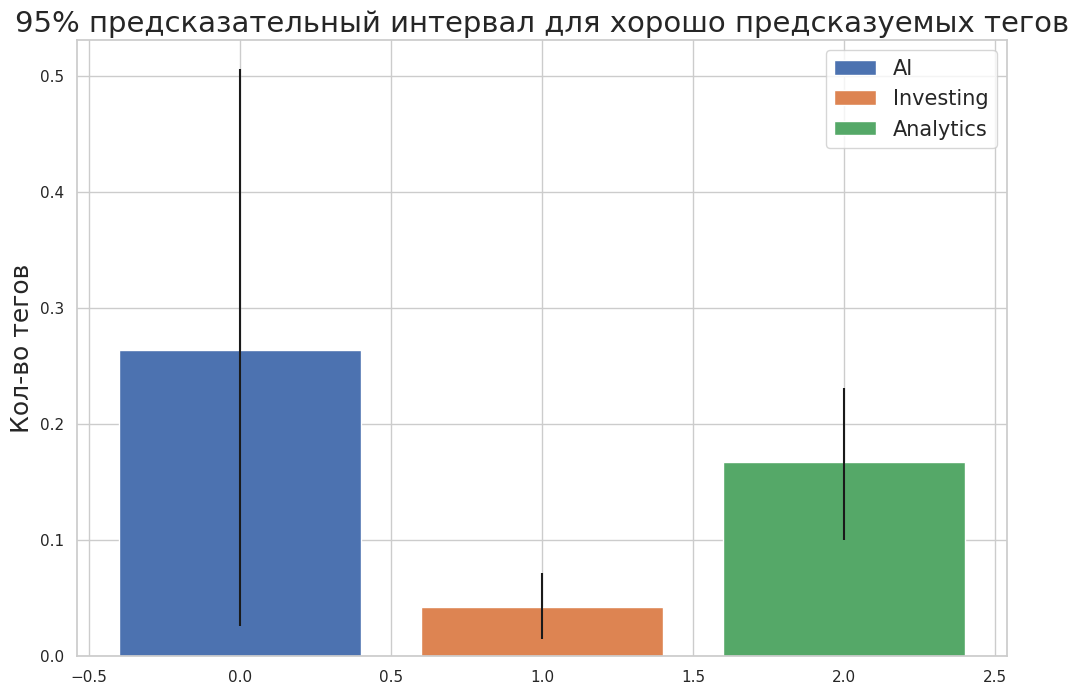

In [298]:
plt.figure(figsize=(12, 8))
norm_const = df_one_hot_tags.iloc[-1, :].sum()

for i, pred in enumerate(preds):
    plt.bar(x=i,
           height=pred["yhat"] / norm_const,
           yerr=np.array((
               (pred["yhat"] - pred["yhat_lower"]) / norm_const,
               (pred["yhat_upper"] - pred["yhat"]) / norm_const
           )).reshape(-1, 1),
           label=good_data.columns[i + 1],
          )

plt.ylabel("Кол-во тегов", fontsize=18)
plt.title("95% предсказательный интервал для хорошо предсказуемых тегов", fontsize=21)
    
plt.legend(fontsize=15)
plt.show()